# Aufgabe 1

In [1]:
import numpy as np
from scipy.sparse import csr_matrix

import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from utils import get_google, get_wiki, neighbors

In [2]:
WIKI_START = 46
GOOGLE_START = 11432

In [3]:
def markovian_spectral_ranking(G, eps=1e-8):
    V = G.nodes()
    N = G.number_of_nodes()
    r = np.ones(N).T / N
    M = nx.adjacency_matrix(G).toarray()

    d = M.sum(axis=1, keepdims=True)  # out degree
    d[d == 0] = 1
    M = csr_matrix((M / d).T)

    for i in range(1 << 20):
        r0, r = r, M @ r
        if np.linalg.norm(r0 - r) < eps: break

    print(f'Took {i + 1} iterations')
    return dict(zip(V, r.tolist()))

In [4]:
def top_nodes(rank_dict, count=5, as_dict=True):
    top = sorted(rank_dict.keys(), key=rank_dict.get, reverse=True)[:count]
    return {k: rank_dict[k] for k in top} if as_dict else top

In [5]:
def plot_bar(V, msr, pr):
    msr_values = [msr[v] for v in V]
    pr_values = [pr[v] for v in V]

    x = range(len(V))
    width = 0.35

    fig, ax1 = plt.subplots(figsize=(12, 6))

    bars1 = ax1.bar(x, msr_values, width, label='Markovian Spectral Ranking', color='blue')
    ax1.set_ylabel('MSR Score')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    bars2 = ax2.bar([i + width for i in x], pr_values, width, label='True PageRank', color='orange')
    ax2.set_ylabel('PageRank Score')
    ax2.tick_params(axis='y')

    ax1.set_xticks([i + width / 2 for i in x])
    ax1.set_xticklabels(V, rotation=45, ha='right')
    ax1.set_xlabel('Nodes')

    fig.legend([bars1, bars2], ['Markovian Spectral Ranking', 'True PageRank'])

    plt.title('Comparison of PageRank Implementations (Separate Scales)')
    plt.tight_layout()
    plt.show()


def plot_scatter(V, msr, pr):
    msr_values = [msr[v] for v in V]
    pr_values = [pr[v] for v in V]

    xmin, xmax = min(msr_values), max(msr_values)
    ymin, ymax = min(pr_values), max(pr_values)

    plt.figure(figsize=(8, 6))
    plt.scatter(msr_values, pr_values)
    plt.xlabel('Markovian Spectral Ranking')
    plt.ylabel('True PageRank')
    plt.title('Correlation between Rankings')
    plt.plot([xmin, xmax], [ymin, ymax], 'r--')
    plt.show()


def plot(V, msr, pr):
    plot_bar(sorted(V), msr, pr)
    plot_scatter(sorted(msr.keys()), msr, pr)

In [6]:
def aufgabe_1(G, start, eps=1e-8):
    G = neighbors(G, start, 2)
    msr, pr = markovian_spectral_ranking(G, eps), nx.pagerank(G)

    top_msr = top_nodes(msr, 30, False)
    top_pr = top_nodes(pr, 30, False)
    plot({*top_pr, *top_msr}, msr, pr)

    return {'Markovian Spectral Ranking': top_nodes(msr), 'PageRank': top_nodes(pr)}

In [7]:
google = get_google()

Reading graph from file:   0%|          | 0/5105043 [00:00<?, ?it/s]

Took 127 iterations


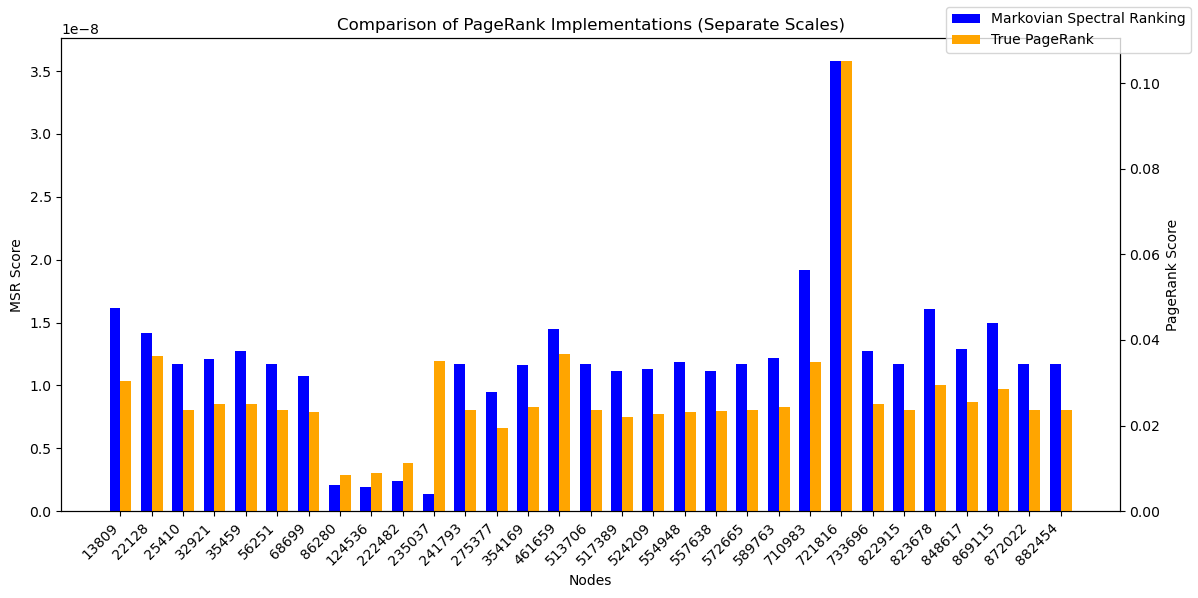

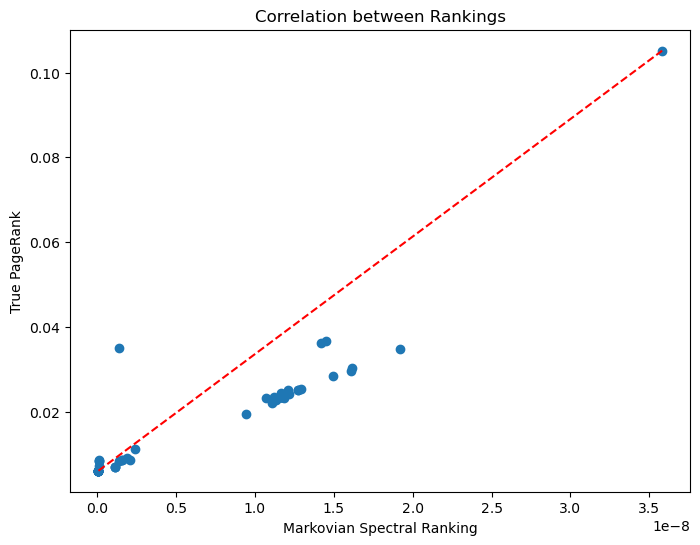

{'Markovian Spectral Ranking': {721816: 3.580818081871725e-08,
  710983: 1.9215969350977583e-08,
  13809: 1.6182235100847578e-08,
  823678: 1.6080734069991184e-08,
  869115: 1.4961858635900492e-08},
 'PageRank': {721816: 0.10516349611930445,
  461659: 0.036600518545189795,
  22128: 0.03626533439776253,
  235037: 0.035112579338122105,
  710983: 0.03485159183648259}}

In [8]:
aufgabe_1(google, GOOGLE_START)

In [9]:
wiki = get_wiki()

Reading graph from file:   0%|          | 0/28511807 [00:00<?, ?it/s]

Took 5 iterations


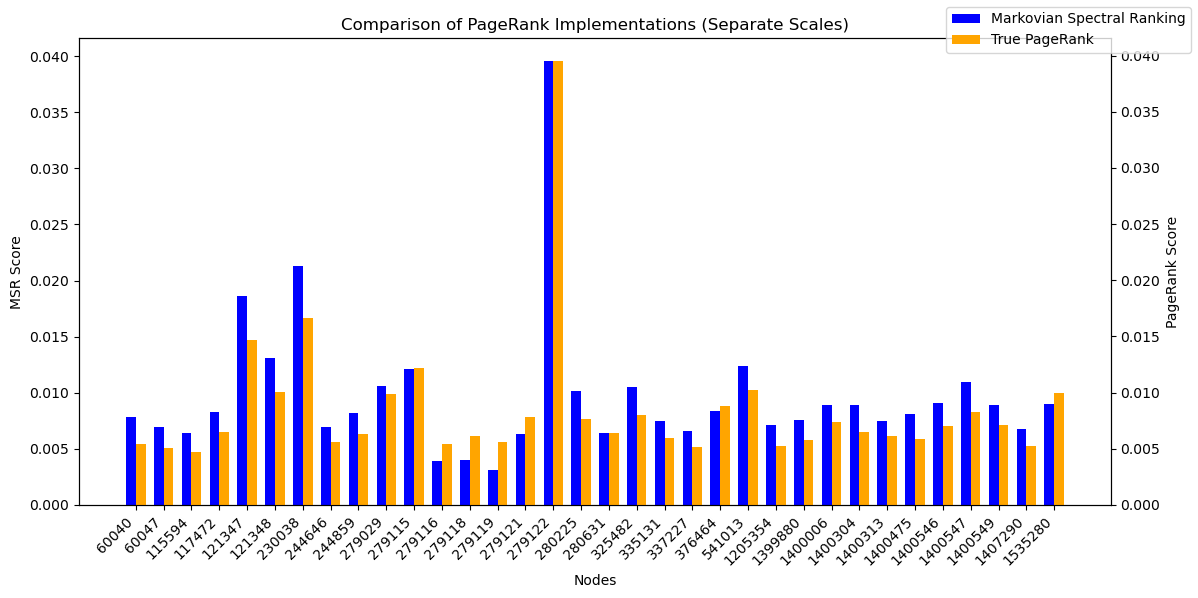

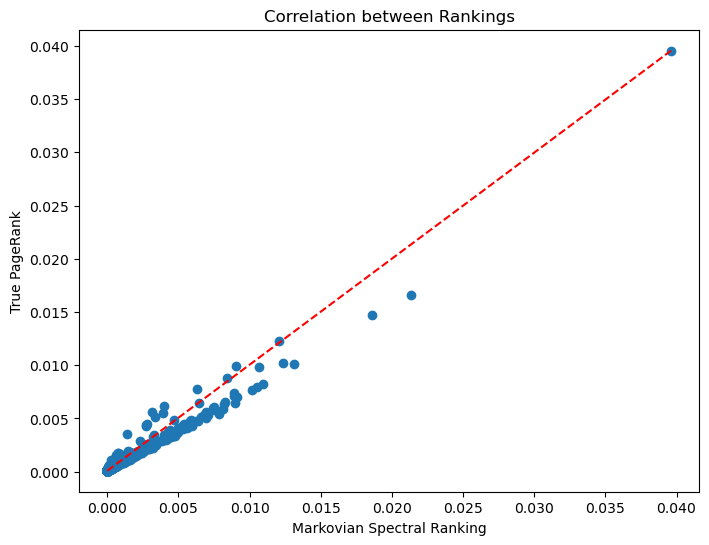

{'Markovian Spectral Ranking': {279122: 0.039607408315551616,
  230038: 0.02133726649246432,
  121347: 0.018591011664401358,
  121348: 0.01313799927180693,
  541013: 0.012372072640382231},
 'PageRank': {279122: 0.03955338014884857,
  230038: 0.016640872138236583,
  121347: 0.014671689772198925,
  279115: 0.012227683983410153,
  541013: 0.010240967799962152}}

In [10]:
aufgabe_1(wiki, WIKI_START, 1e-2)

The smaller eps is the more it diverges??

# Aufgabe 2

In der VL wurde bereits gezeigt, dass man das $r$ array, aka den Eigenvektor, auch Abschnittsweise berechnen kann. Denn für einen Eintrag $r_j$ im Array braucht man nicht die volle Matrix $M$, sondern nur die korrespondierende Zeile.

# Aufgabe 3

In [11]:
import time
import json
import asyncio
from aiosseclient import aiosseclient
import nest_asyncio  # because of jupyter
from tqdm.asyncio import tqdm

nest_asyncio.apply()

In [12]:
EVENT_SERVER = 'https://stream.wikimedia.org/v2/stream/recentchange'

In [13]:
async def aufgabe_3():
    bot_count = 0
    change_count = 0
    start_time = time.time()
    duration = 60  # reduced because of constant crashes

    async for event in tqdm(aiosseclient(EVENT_SERVER)):
        if event.event != 'message': continue

        try:
            change = json.loads(event.data)
        except:
            continue

        change_count += 1
        bot_count += change.get('bot', 0)

        if time.time() - start_time > duration:
            return bot_count, change_count

In [14]:
loop = asyncio.get_event_loop()
loop.run_until_complete(aufgabe_3())

2030it [01:00, 33.78it/s]


(957, 2030)